# Integrantes do grupo
**Daniel Kenichi Tiago Tateishi** RA:790837

**João Dini de Miranda** RA: 790716

## Etapa 1 a 5
Selecionamos o conjunto de dados [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). 

O conjunto está disponível em `sklearn.datasets`. 

Fazemos a conversão do conjunto de dados para um DataFrame do Pandas para melhor visualização e tratamento dos dados.

Os atributos nominais do conjunto "Maligno" e "Benigno" já estão no formato binário e portanto não necessitam de conversão.

In [ ]:
# Importando bibliotecas utilizadas
import numpy as np
import pandas as pd
import statistics
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import load_breast_cancer
from matplotlib import pyplot as plt

# Ignorando warnings 
import warnings
warnings.filterwarnings('ignore')

# Carregando o banco de dados utilizado
breast_cancer = load_breast_cancer()
#X = breast_cancer.data
#Y = breast_cancer.target

# Convertendo o dataset para DataFrame do Pandas
data = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
data['class'] = breast_cancer.target
#Y = data['class']   
#X = data.drop('class', axis=1)  

data = data.sample(frac=1).reset_index(drop=True)
data #Exibindo dados

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,10.260,12.22,65.75,321.6,0.09996,0.07542,0.01923,0.01968,0.1800,0.06569,...,15.65,73.23,394.5,0.1343,0.16500,0.08615,0.06696,0.2937,0.07722,1
1,11.620,18.18,76.38,408.8,0.11750,0.14830,0.10200,0.05564,0.1957,0.07255,...,25.40,88.14,528.1,0.1780,0.28780,0.31860,0.14160,0.2660,0.09270,1
2,16.250,19.51,109.80,815.8,0.10260,0.18930,0.22360,0.09194,0.2151,0.06578,...,23.05,122.10,939.7,0.1377,0.44620,0.58970,0.17750,0.3318,0.09136,0
3,19.530,18.90,129.50,1217.0,0.11500,0.16420,0.21970,0.10620,0.1792,0.06552,...,26.24,171.10,2053.0,0.1495,0.41160,0.61210,0.19800,0.2968,0.09929,0
4,16.780,18.80,109.30,886.3,0.08865,0.09182,0.08422,0.06576,0.1893,0.05534,...,26.30,130.70,1260.0,0.1168,0.21190,0.23180,0.14740,0.2810,0.07228,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,12.750,16.70,82.51,493.8,0.11250,0.11170,0.03880,0.02995,0.2120,0.06623,...,21.74,93.63,624.1,0.1475,0.19790,0.14230,0.08045,0.3071,0.08557,1
565,16.030,15.51,105.80,793.2,0.09491,0.13710,0.12040,0.07041,0.1782,0.05976,...,21.98,124.30,1070.0,0.1435,0.44780,0.49560,0.19810,0.3019,0.09124,0
566,20.090,23.86,134.70,1247.0,0.10800,0.18380,0.22830,0.12800,0.2249,0.07469,...,29.43,158.80,1696.0,0.1347,0.33910,0.49320,0.19230,0.3294,0.09469,0
567,7.691,25.44,48.34,170.4,0.08668,0.11990,0.09252,0.01364,0.2037,0.07751,...,31.89,54.49,223.6,0.1596,0.30640,0.33930,0.05000,0.2790,0.10660,1


## Etapa 6

Após isso, dividimos o dataframe em 10 "folds" para poder dividir os dados em dados de treinamento e dados de teste.

---

Para realizar a divisão, verificamos o tamanho mínimo de cada fold em `mfold_size`, e quantas amostras sobrariam caso dividissemos os folds com exatamente o mesmo tamanho e armazenamos esse valor em `r`. Dessa forma, conseguimos gerar os folds com a distribuição das sobras previamente calculada (para os folds com posição menor que `k - r`, recebem o tamanho mínimo, para folds com index maior que `k - r`, é feito a distribuição das amostras que sobraram).

Por exemplo, se fossemos dividir 14 amostras em 10 folds, teriamos um conjunto de folds em que o tamanho de cada fold seria representado pelo conjunto [1, 1, 1, 1, 1, 1, 2, 2, 2, 2].

In [ ]:
# Número de folds
k = 10 
# Restante a ser redistribuido nos folds
r = len(data.index)%k
# Tamanho mínimo de um fold
mfold_size = (len(data.index) // k)
pos = 0
folds = []
for i in range(k):
  if i < k - r:
    folds.append(data.iloc[pos : pos + mfold_size, :])
    pos += mfold_size
  else:
    folds.append(data.iloc[pos : pos + mfold_size + 1, :])
    pos += mfold_size + 1
      
#print(folds) # Imprimir folds gerados

## Etapa 7 e 8
Agora com os folds gerados, vamos avaliar um algoritmo de indução de árvores de decisão usando a estratégia 10-fold cross-validation.

Usamos a função `fit()` para obter o "estimador" gerado pelo o algoritmo.



In [ ]:
# Resultado de cada iteração
clfs = []    

# Conjunto X (Treino/Teste)
X_train = [] 
X_test = []

# Conjunto Y (Treino/Teste)
Y_train = [] 
Y_test = []

# Cada iteração avalia o algoritmo em uma variação de Treino/Teste usando os folds
for i in range(k):
  # Obtendo e armazenando os conjuntos de treino/teste dessa iteração
  test = folds[i]
  train = pd.DataFrame(None)
  for j in range(k):
    if j != i:
      train = pd.concat([train, folds[j]], ignore_index = True, axis = 0)

  Y_test.append(test['class'])
  Y_train.append(train['class'])
  X_train.append(train.drop('class', axis = 1))
  X_test.append(test.drop('class', axis = 1))

  # Treinando o algoritmo
  clf = tree.DecisionTreeClassifier(criterion='entropy')
  # Adicionando o resultado à lista de resultados
  clfs.append(clf.fit(X_train[i], Y_train[i]))




## Etapa 9
Gerando a figura da árvore de decisão de uma das iterações do cross-fold

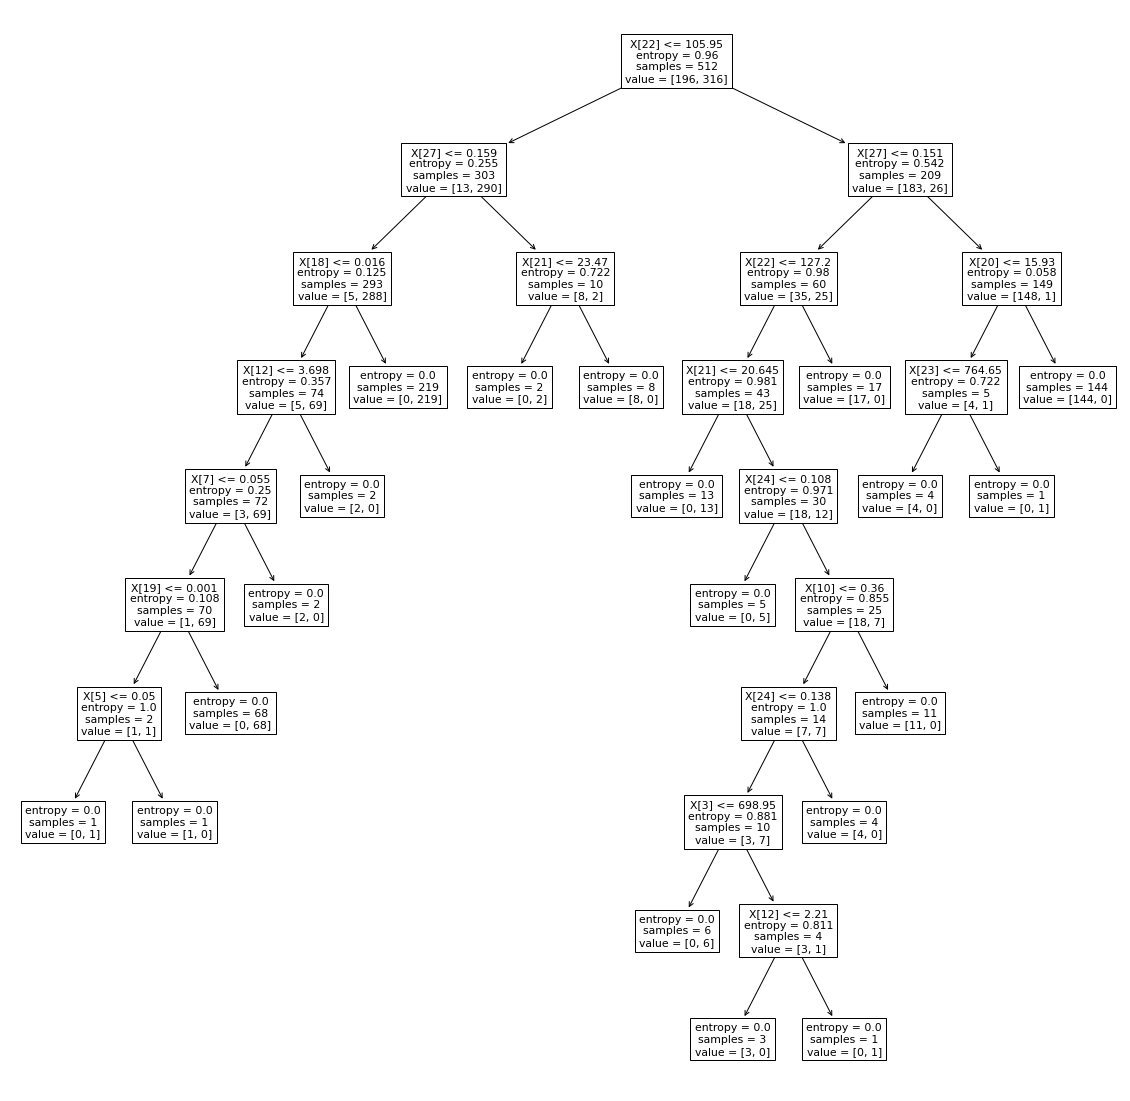

In [ ]:
fig = plt.figure(figsize=(20,20))
fig = tree.plot_tree(clfs[0])

## Etapa 10 e 11

Para cada iteração do algoritmo, fazemos a classificação dos seus dados de teste usando `.predict()`

Ao mesmo tempo, calculamos para essa iteração a matriz de confusão (`confusion_matrix()`) e o relatório da classificação (`classification_report()`) que podem ser vistos impressos a seguir.

Matrizes de confusão e relatórios individuais


🡆🡆 0 🡄🡄



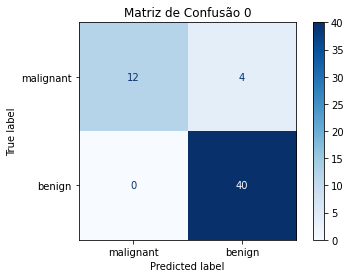


Relatório da classificação 0: 

              precision    recall  f1-score  support
0              1.000000  0.750000  0.857143     16.0
1              0.909091  1.000000  0.952381     40.0
accuracy       0.928571  0.928571  0.928571     56.0
macro avg      0.954545  0.875000  0.904762     56.0
weighted avg   0.935065  0.928571  0.925170     56.0


🡆🡆 1 🡄🡄



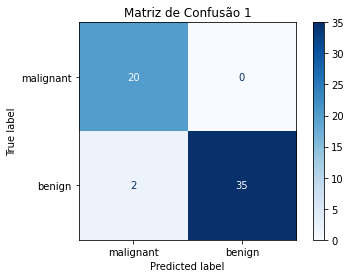


Relatório da classificação 1: 

              precision    recall  f1-score  support
0              0.909091  1.000000  0.952381     20.0
1              1.000000  0.945946  0.972222     37.0
accuracy       0.964912  0.964912  0.964912     57.0
macro avg      0.954545  0.972973  0.962302     57.0
weighted avg   0.968102  0.964912  0.965260     57.0


🡆🡆 2 🡄🡄



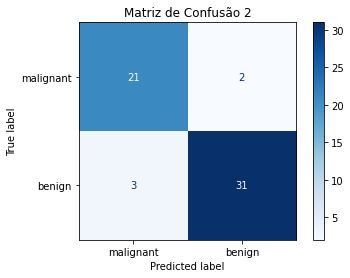


Relatório da classificação 2: 

              precision    recall  f1-score  support
0              0.875000  0.913043  0.893617     23.0
1              0.939394  0.911765  0.925373     34.0
accuracy       0.912281  0.912281  0.912281     57.0
macro avg      0.907197  0.912404  0.909495     57.0
weighted avg   0.913410  0.912281  0.912559     57.0


🡆🡆 3 🡄🡄



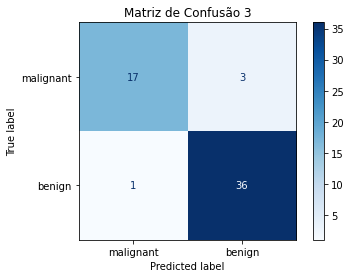


Relatório da classificação 3: 

              precision    recall  f1-score  support
0              0.944444  0.850000  0.894737     20.0
1              0.923077  0.972973  0.947368     37.0
accuracy       0.929825  0.929825  0.929825     57.0
macro avg      0.933761  0.911486  0.921053     57.0
weighted avg   0.930574  0.929825  0.928901     57.0


🡆🡆 4 🡄🡄



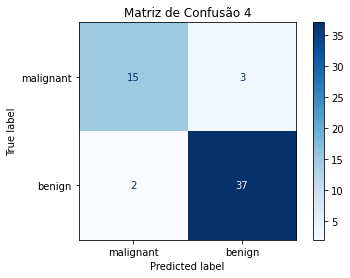


Relatório da classificação 4: 

              precision    recall  f1-score  support
0              0.882353  0.833333  0.857143     18.0
1              0.925000  0.948718  0.936709     39.0
accuracy       0.912281  0.912281  0.912281     57.0
macro avg      0.903676  0.891026  0.896926     57.0
weighted avg   0.911533  0.912281  0.911583     57.0


🡆🡆 5 🡄🡄



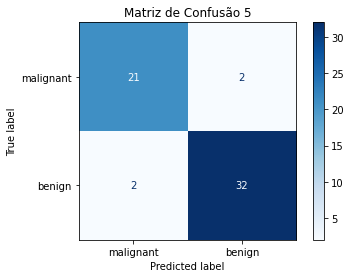


Relatório da classificação 5: 

              precision    recall  f1-score  support
0              0.913043  0.913043  0.913043     23.0
1              0.941176  0.941176  0.941176     34.0
accuracy       0.929825  0.929825  0.929825     57.0
macro avg      0.927110  0.927110  0.927110     57.0
weighted avg   0.929825  0.929825  0.929825     57.0


🡆🡆 6 🡄🡄



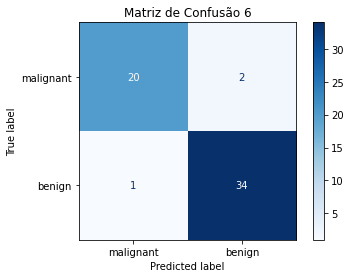


Relatório da classificação 6: 

              precision    recall  f1-score  support
0              0.952381  0.909091  0.930233     22.0
1              0.944444  0.971429  0.957746     35.0
accuracy       0.947368  0.947368  0.947368     57.0
macro avg      0.948413  0.940260  0.943990     57.0
weighted avg   0.947508  0.947368  0.947127     57.0


🡆🡆 7 🡄🡄



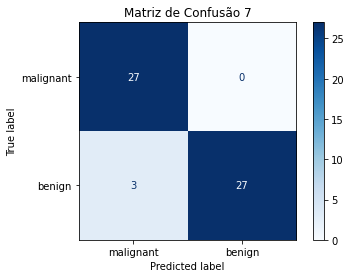


Relatório da classificação 7: 

              precision    recall  f1-score  support
0              0.900000  1.000000  0.947368     27.0
1              1.000000  0.900000  0.947368     30.0
accuracy       0.947368  0.947368  0.947368     57.0
macro avg      0.950000  0.950000  0.947368     57.0
weighted avg   0.952632  0.947368  0.947368     57.0


🡆🡆 8 🡄🡄



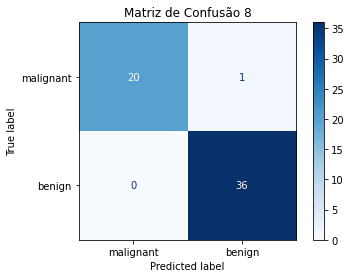


Relatório da classificação 8: 

              precision    recall  f1-score  support
0              1.000000  0.952381  0.975610     21.0
1              0.972973  1.000000  0.986301     36.0
accuracy       0.982456  0.982456  0.982456     57.0
macro avg      0.986486  0.976190  0.980956     57.0
weighted avg   0.982930  0.982456  0.982362     57.0


🡆🡆 9 🡄🡄



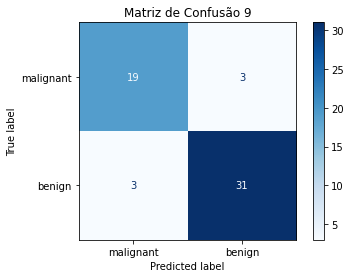


Relatório da classificação 9: 

              precision    recall  f1-score  support
0              0.863636  0.863636  0.863636     22.0
1              0.911765  0.911765  0.911765     34.0
accuracy       0.892857  0.892857  0.892857     56.0
macro avg      0.887701  0.887701  0.887701     56.0
weighted avg   0.892857  0.892857  0.892857     56.0


In [ ]:
print("Matrizes de confusão e relatórios individuais")
class_reports = [] # Lista dos relatórios de classificação

for i in range(k):  
  print(f"\n\n🡆🡆 {i} 🡄🡄\n")

  # Classificação dos algoritmos com o conjunto de testes
  predicted = clfs[i].predict(X_test[i])

  # Gerando matriz de confusão
  class_names = breast_cancer.target_names
  title = f"Matriz de Confusão {i}"
  disp = plot_confusion_matrix(clfs[i], X_test[i], Y_test[i], display_labels=class_names, cmap=plt.cm.Blues)
  disp.ax_.set_title(title)
  plt.show()
  
  # Gerando relatórios da classificação
  cr = classification_report(Y_test[i], predicted, output_dict=True)
  class_reports.append(pd.DataFrame(cr).transpose()) # Convertendo para DataFrames
  class_reports[i].iloc[2,3] = class_reports[i].iloc[3,3] 
  print(f"\nRelatório da classificação {i}: \n") 
  print(class_reports[i])
 

## Etapa 12
Calculando a média e o desvio padrão dentre as diferentes iterações do algoritmo.

Para cada campo do relatório da classificação calculamos a média e o desvio padrão.

In [ ]:
# Usando dataframe como base para os novos
media_df = class_reports[0].copy()
desvio_df = class_reports[0].copy()

# Seleciona o campo do relatório
for i in range(len(class_reports[0])):
  for j in range(len(class_reports[0].columns)):
    # Percorre os relatórios, na mesma posição e adiciona em uma lista
    valores_ij = []
    for cr in class_reports:
      valores_ij.append(cr.iloc[i][j])
    # Calcula Média e Desvio Padrão
    media_df.iloc[i][j] = statistics.mean(valores_ij)
    desvio_df.iloc[i][j] = statistics.pstdev(valores_ij)

# Exibindo Média e Desvio Padrão
print("Média")
print(media_df)
print()
print("Desvio Padrão")
print(desvio_df)

Média
              precision    recall  f1-score  support
0              0.923995  0.898453  0.908491     21.2
1              0.946692  0.950377  0.947841     35.6
accuracy       0.934774  0.934774  0.934774     56.8
macro avg      0.935343  0.924415  0.928166     56.8
weighted avg   0.936444  0.934774  0.934301     56.8

Desvio Padrão
              precision    recall  f1-score   support
0              0.046339  0.073423  0.040164  2.856571
1              0.031820  0.033920  0.020414  2.727636
accuracy       0.025210  0.025210  0.025210  0.400000
macro avg      0.028060  0.033418  0.028518  0.400000
weighted avg   0.025843  0.025210  0.025382  0.400000
